## 1. Required libraries

In [4]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pylab
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
import json
from collections import Counter
import random
from operator import itemgetter
from IPython.display import Image, display


## 2. Pull and prepare the data

In [5]:

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 30})
sns.set_style("darkgrid", {'axes.grid' : True})

df=pd.read_csv(r'C:\Users\quilo\Desktop\Classification\labels.csv')
df['files']=df['id']+'.jpg'
rows = np.random.randint(2, size=len(df)).astype('bool')
df_cal=df[rows]
df_test=df[~rows]
y_cal=df_cal['breed'].values
y_test=df_test['breed'].values
image_dir = r'C:\Users\quilo\Desktop\Classification'
img_paths_cal = [join(image_dir, filename) for filename in df_cal['files'].values]
img_paths_test = [join(image_dir, filename) for filename in df_test['files'].values]

In [6]:


image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return output

In [7]:
my_model = ResNet50(weights='imagenet')
cal_data=read_and_prep_images(img_paths_cal)
test_data=read_and_prep_images(img_paths_test)
y_cal_preds = my_model.predict(cal_data)

In [8]:
# Opening JSON file
with open(r'C:\Users\quilo\Desktop\Classification\imagenet_class_index.json') as json_file:
    encoder = json.load(json_file)
decoder={}

for k,v in encoder.items():
    decoder[v[1].lower()]=int(k)
    encoder[k]=v[1].lower()

## 3. Classification Inductive Conformal Prediction 

## 3.1 Naive method

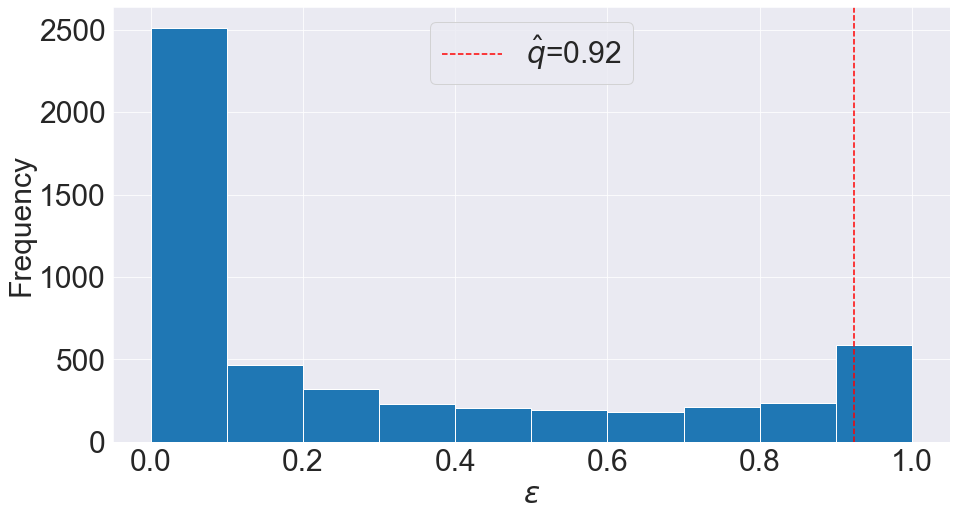

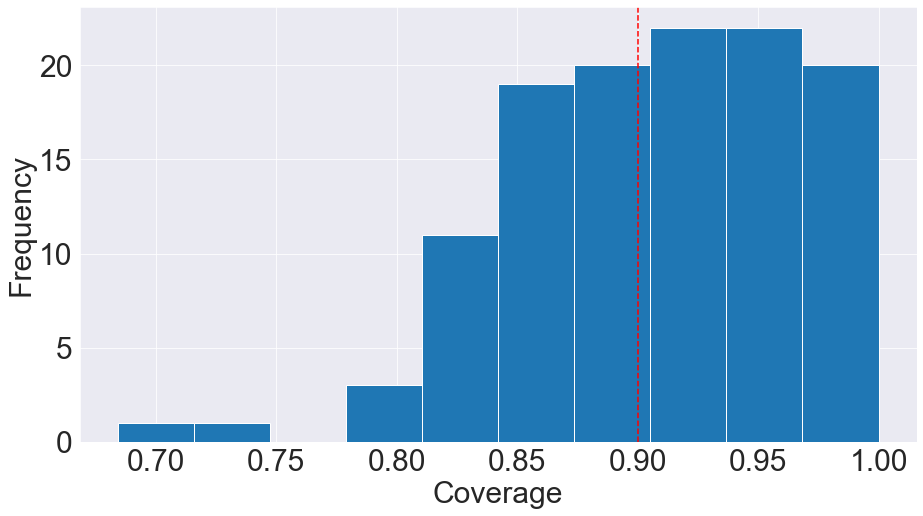

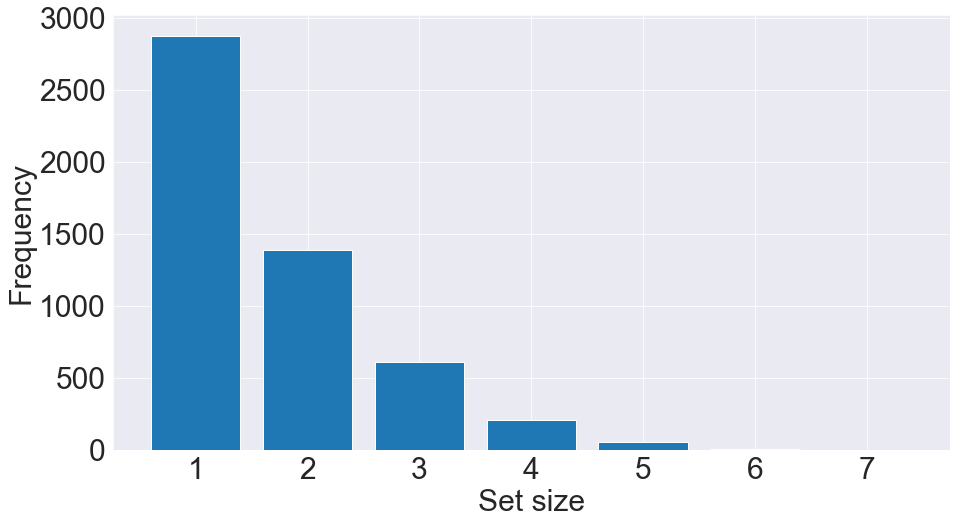

In [28]:


def compute_qyhat_naive(y_cal,y_cal_preds,decoder,alpha=0.1):
    
    n=len(y_cal)
    scores=[]

    for i in range(y_cal_preds.shape[0]):
        try:
            scores.append(1-y_cal_preds[i][decoder[y_cal[i]]])
        except Exception:
            pass
    
    scores=np.array(scores)
    q_yhat=np.quantile(scores,np.ceil((n+1)*(1-alpha))/n)
    
    return q_yhat,scores

def show_hist_scores(scores,q_yhat):
    plt.hist(scores)
    plt.axvline(x=q_yhat, color='r', linestyle='--',label=r'$\hat{q}$='+str(round(q_yhat,2)))
    plt.xlabel(r'$\epsilon$')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
def build_conf_sets_naive(y_pred,q_yhat):
    conf_sets=[]
    
    for i in range(y_pred.shape[0]):
        aux=[]
        for j in range(y_pred.shape[1]):
            if y_pred[i][j]>=1-q_yhat:
                aux.append(j)
        conf_sets.append(aux)
    
    return conf_sets

def show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat,alpha=0.1):
    conf_sets=build_conf_sets_naive(y_cal_preds,q_yhat)
    d_counts=Counter(y_cal)
    d_coverages={}
    
    
    for i in range(len(conf_sets)):
        if decoder[y_cal[i]] in conf_sets[i]:
            if y_cal[i] in d_coverages:
                d_coverages[y_cal[i]]+=1
            else:
                d_coverages[y_cal[i]]=1
    
    for k in d_coverages.keys():
        d_coverages[k]=d_coverages[k]/d_counts[k]
    
    plt.hist(d_coverages.values())
    plt.axvline(x=1-alpha, color='r', linestyle='--',label=r'$\alpha$='+str(alpha))
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.show()

def show_bar_setsize(y_cal_preds,q_yhat):
    conf_sets=build_conf_sets_naive(y_cal_preds,q_yhat)
    d_counts={}
    
    for conf_set in conf_sets:
        dim=len(conf_set)
        if dim in d_counts:
            d_counts[dim]+=1
        else:
            d_counts[dim]=1
        
    plt.bar(d_counts.keys(),d_counts.values())
    plt.xlabel('Set size')
    plt.ylabel('Frequency')
    plt.show()
     
    #d_coverages = dict(sorted(d_coverages.items(), key = itemgetter(1))[:3])
    
    #plt.bar(*zip(*d_coverages.items()))
    #plt.axhline(y=1-alpha, color='r', linestyle='--',label=r'$\alpha$='+str(1-alpha))
    #plt.xlabel('Class')
    #plt.ylabel('Coverage')
    #plt.legend()
    #plt.show()
        
    
    

q_yhat,scores=compute_qyhat_naive(y_cal,y_cal_preds,decoder,alpha=0.1)
show_hist_scores(scores,q_yhat)
show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat,alpha=0.1)
show_bar_setsize(y_cal_preds,q_yhat)

## 3.2 Class-balanced 

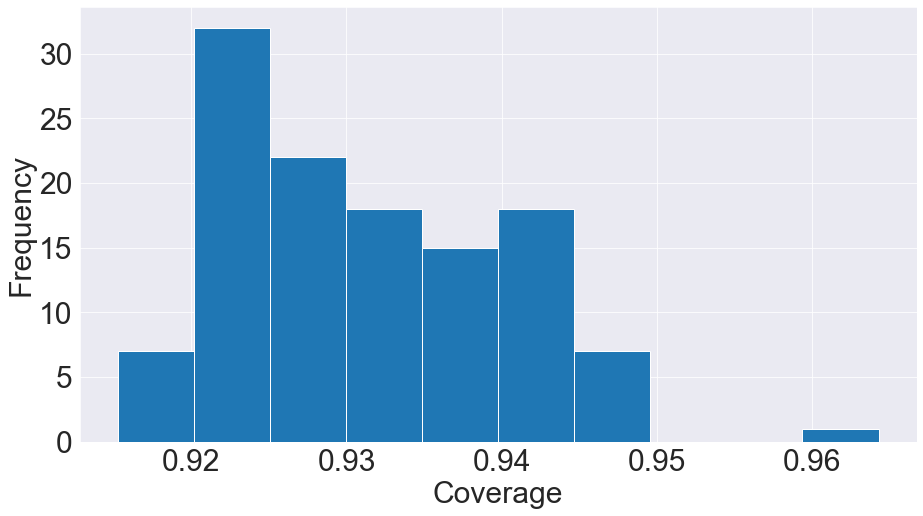

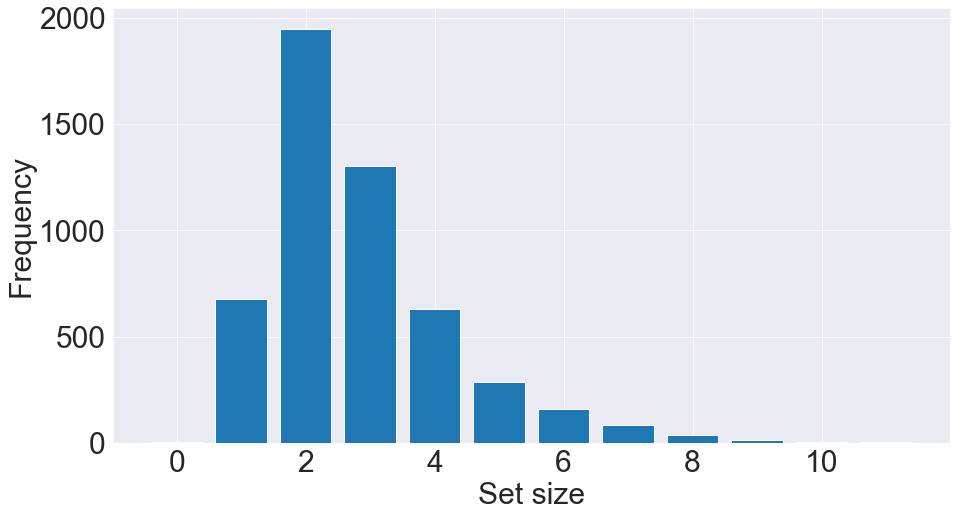

In [44]:


def compute_qyhat_classbalanced(y_cal,y_cal_preds,decoder,alpha=0.1):
    
    scores={}
    q_yhat_class={}

    for i in range(y_cal_preds.shape[0]):
        true_class= decoder[y_cal[i]]
        
        if true_class in scores:
            scores[true_class].append(1-y_cal_preds[i][true_class])
        else:
            scores[true_class]=[1-y_cal_preds[i][true_class]]
    
    for k,v in scores.items():
        n=len(scores[k])
        q_yhat_class[k]=np.quantile(scores[k],np.ceil((n+1)*(1-alpha))/n)
    
    return q_yhat_class


def build_conf_sets_classbalanced(y_pred,q_yhat_class):
    conf_sets=[]
    
    for i in range(y_pred.shape[0]):
        aux=[]
        for j in range(y_pred.shape[1]):
            if j in q_yhat_class and y_pred[i][j]>=1-q_yhat_class[j]:
                aux.append(j)
        conf_sets.append(aux)
    
    return conf_sets

def show_bar_setsize(y_cal_preds,q_yhat_class):
    conf_sets=build_conf_sets_classbalanced(y_cal_preds,q_yhat_class)
    d_counts={}
    
    for conf_set in conf_sets:
        dim=len(conf_set)
        if dim in d_counts:
            d_counts[dim]+=1
        else:
            d_counts[dim]=1
        
    plt.bar(d_counts.keys(),d_counts.values())
    plt.xlabel('Set size')
    plt.ylabel('Frequency')
    plt.show()
    
def show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat_class,alpha=0.1):
    conf_sets=build_conf_sets_classbalanced(y_cal_preds,q_yhat_class)
    d_counts=Counter(y_cal)
    d_coverages={}
    
    
    for i in range(len(conf_sets)):
        if decoder[y_cal[i]] in conf_sets[i]:
            if y_cal[i] in d_coverages:
                d_coverages[y_cal[i]]+=1
            else:
                d_coverages[y_cal[i]]=1
    
    for k in d_coverages.keys():
        d_coverages[k]=d_coverages[k]/d_counts[k]
    
    plt.hist(d_coverages.values())
   # plt.axvline(x=1-alpha, color='r', linestyle='--',label=r'$\alpha$='+str(alpha))
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.show()


        
    
    

#q_yhat,scores=compute_qyhat_naive(y_cal,y_cal_preds,decoder,alpha=0.1)
#show_hist_scores(scores,q_yhat)
#show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,alpha=0.1)
q_yhat_class=compute_qyhat_classbalanced(y_cal,y_cal_preds,decoder,alpha=0.1)
show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat_class,alpha=0.1)
show_bar_setsize(y_cal_preds,q_yhat_class)

## 3.3 Adaptive prediction sets

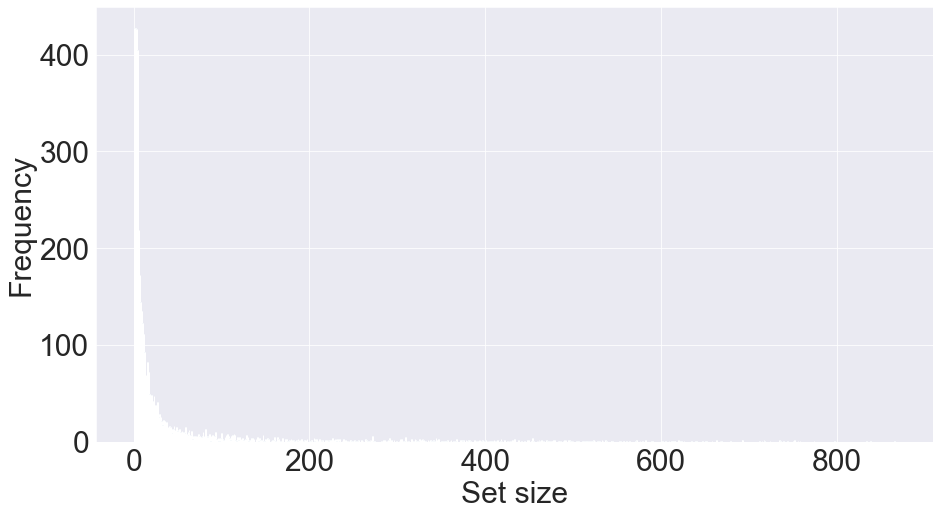

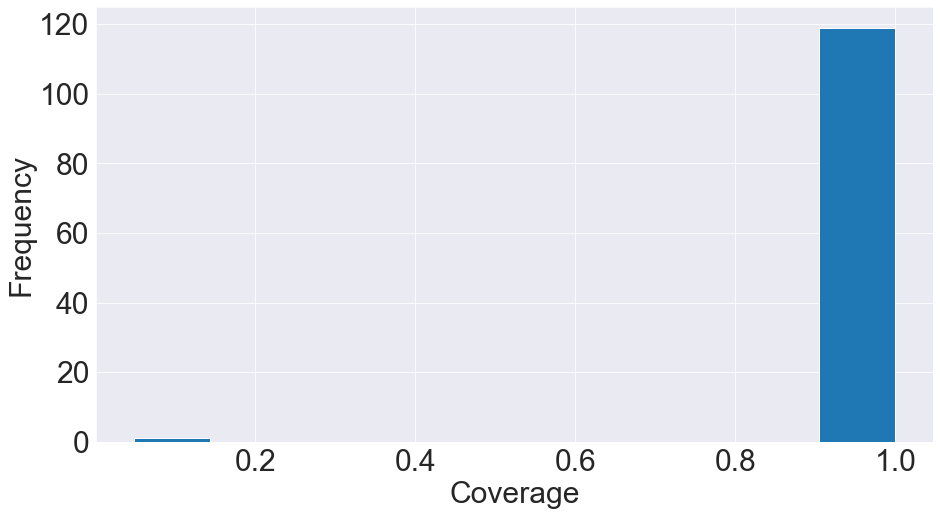

In [49]:
def compute_qyhat_APS(y_cal,y_cal_preds,decoder,alpha=0.1):
    
    n=len(y_cal)
    scores=[]

    for i in range(y_cal_preds.shape[0]):
        
        cum_density=0
        ind_sorted=np.argsort(y_cal_preds[i])
        k=len(ind_sorted)-1
        true_class_bool=False
        true_class=decoder[y_cal[i]]
        
        while k>=0 and true_class_bool==False:
            cum_density+=y_cal_preds[i][ind_sorted[k]]
            if ind_sorted[k]==true_class:
                true_class_bool=True
            k-=1
                
        scores.append(cum_density)
        
    scores=np.array(scores)
    q_yhat_APS=np.quantile(scores,np.ceil((n+1)*(1-alpha))/n)
    
    return q_yhat_APS

def build_conf_sets_APS(y_pred,q_yhat_APS):
    conf_sets=[]
    
    for i in range(y_pred.shape[0]):
        aux=[]
        ind_sorted=np.argsort(y_pred[i])
        k=len(ind_sorted)-1
        cum_density=0
        
        while cum_density<q_yhat_APS:
            cum_density+=y_pred[i][ind_sorted[k]]
            aux.append(ind_sorted[k])
            k-=1
            
        conf_sets.append(aux)
    
    return conf_sets

def show_bar_setsize(y_cal_preds,q_yhat_APS):
    conf_sets=build_conf_sets_APS(y_cal_preds,q_yhat_APS)
    d_counts={}
    
    for conf_set in conf_sets:
        dim=len(conf_set)
        if dim in d_counts:
            d_counts[dim]+=1
        else:
            d_counts[dim]=1
        
    plt.bar(d_counts.keys(),d_counts.values())
    plt.xlabel('Set size')
    plt.ylabel('Frequency')
    plt.show()
    
def show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat_APS,alpha=0.1):
    conf_sets=build_conf_sets_APS(y_cal_preds,q_yhat_APS)
    d_counts=Counter(y_cal)
    d_coverages={}
    
    
    for i in range(len(conf_sets)):
        if decoder[y_cal[i]] in conf_sets[i]:
            if y_cal[i] in d_coverages:
                d_coverages[y_cal[i]]+=1
            else:
                d_coverages[y_cal[i]]=1
    
    for k in d_coverages.keys():
        d_coverages[k]=d_coverages[k]/d_counts[k]
    
    plt.hist(d_coverages.values())
   # plt.axvline(x=1-alpha, color='r', linestyle='--',label=r'$\alpha$='+str(alpha))
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.show()

q_yhat_APS=compute_qyhat_APS(y_cal,y_cal_preds,decoder,alpha=0.1)
show_bar_setsize(y_cal_preds,q_yhat_APS)
show_hist_coverage_per_class(y_cal,y_cal_preds,decoder,q_yhat_APS,alpha=0.1)

## Example APS

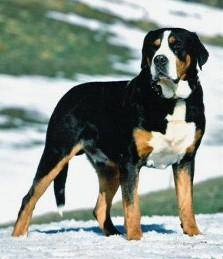

greater_swiss_mountain_dog


In [101]:
i=403
display(Image(img_paths_cal[i]))
print(y_cal[i])

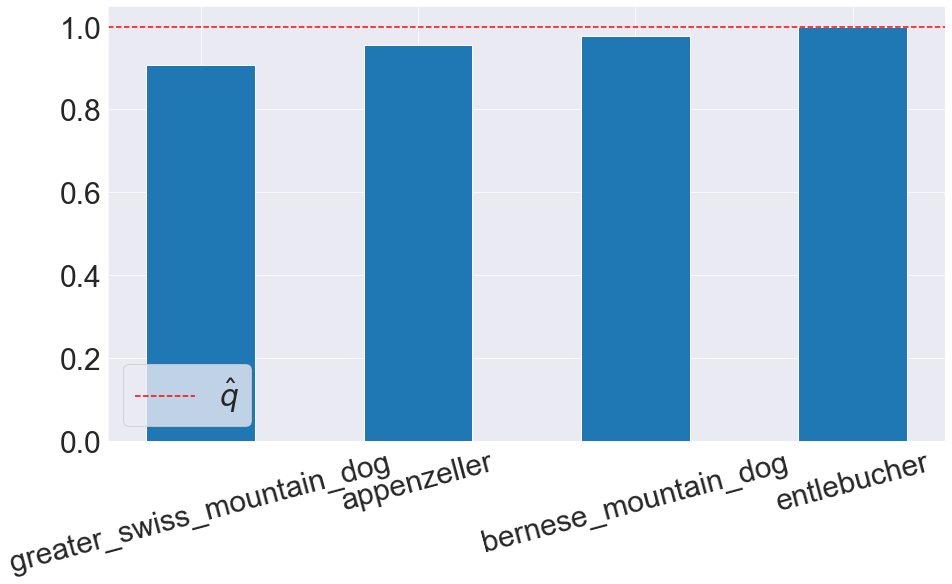

In [107]:
ind_sorted=np.argsort(y_cal_preds[i])
k=len(ind_sorted)-1
cum_density=0
pred_set=[]
classes=[]
cum_density_history=[]
while cum_density<q_yhat_APS:
    cum_density+=y_cal_preds[i][ind_sorted[k]]
    classes.append(ind_sorted[k])
    cum_density_history.append(cum_density)
    pred_set.append(ind_sorted[k])
    k-=1
    
classes_encoded=[encoder[str(c)] for c in classes]

plt.bar(classes_encoded,cum_density_history, align='center',width=0.5)
plt.axhline(y=q_yhat_APS, color='r', linestyle='--',label=r'$\hat{q}$')
plt.legend()
plt.xticks(rotation = 15)
plt.show()

    
    

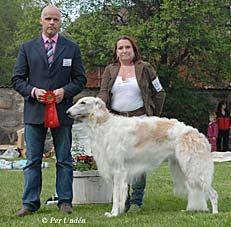

[['borzoi', 0.9979881]]  Ground truth:borzoi


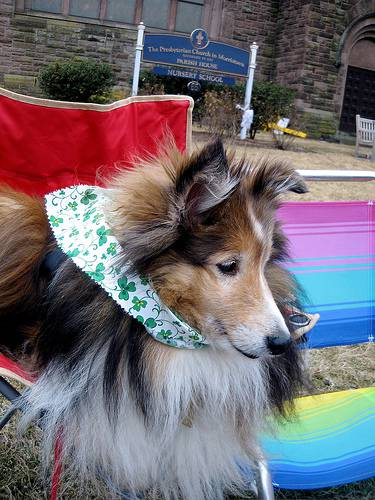

[['Shetland_sheepdog', 0.9765622]]  Ground truth:shetland_sheepdog


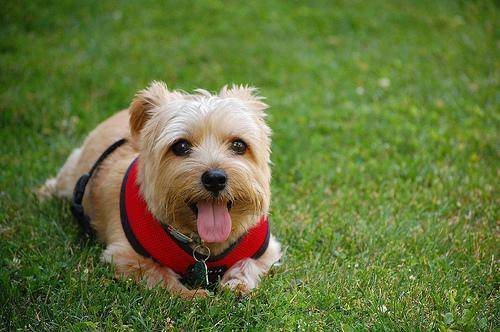

[['Norfolk_terrier', 0.28591424], ['Norwich_terrier', 0.10372889], ['cairn', 0.068172224], ['Dandie_Dinmont', 0.3683918], ['West_Highland_white_terrier', 0.12020066]]  Ground truth:norfolk_terrier


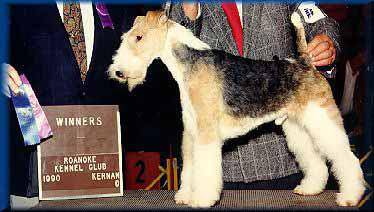

[['wire-haired_fox_terrier', 0.28629947], ['Lakeland_terrier', 0.17193234], ['Airedale', 0.53903383]]  Ground truth:wire-haired_fox_terrier


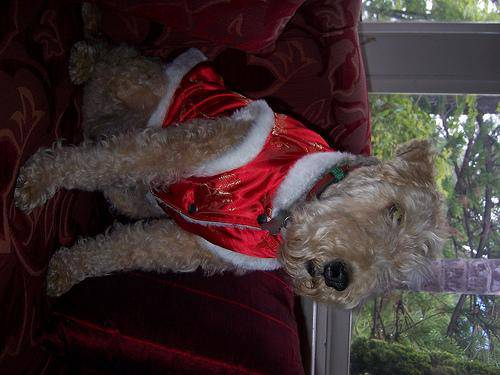

[['Lakeland_terrier', 0.9985563]]  Ground truth:lakeland_terrier


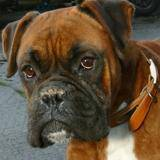

[['boxer', 0.9700298]]  Ground truth:boxer


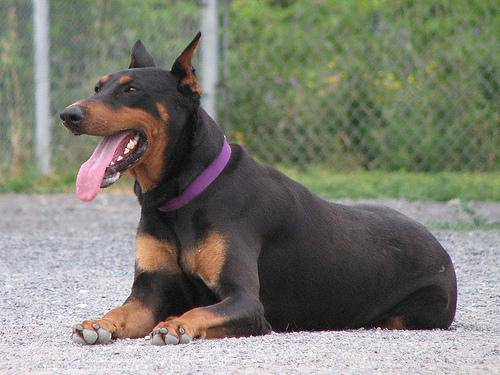

[['Doberman', 0.9768048]]  Ground truth:doberman


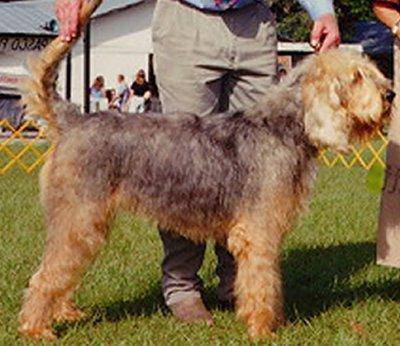

[['otterhound', 0.9994178]]  Ground truth:otterhound


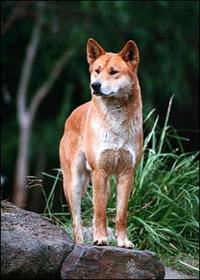

[['dingo', 0.9756048]]  Ground truth:dingo


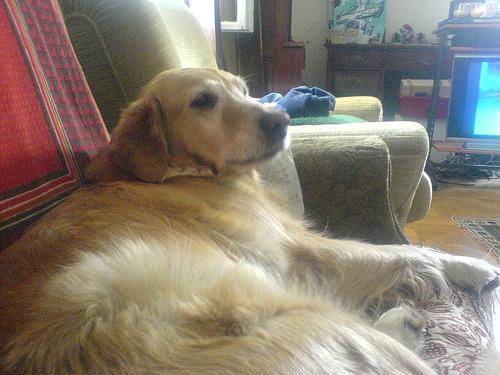

[['golden_retriever', 0.9902796]]  Ground truth:golden_retriever


In [13]:

y_test_preds = my_model.predict(test_data)
conf_sets=build_conf_sets_naive(y_test_preds,q_yhat)
k=10

for i, img_path in enumerate(img_paths_test):
    breeds=[]
    for item in conf_sets[i]:
        breeds.append([decoder[str(item[0])],item[1]])
    if i<k:
        display(Image(img_path))
        print(breeds,' Ground truth:'+str(y_test[i]))
    
   # print(most_likely_labels[i])